In [1]:

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
import json

import copy
import networkx as nx
from tqdm import tqdm
from torch.utils.data import DataLoader
from crp.concepts import ChannelConcept
import time
from expbasics.nmf import sample_cavs, nmf, nearest_neighbors, vis_nearest_neighbors, load_cavs, sample_relevance_cavs, sample_bbox_cavs, sample_all_relevances_cavs

from expbasics.dim_reduction import visualize_dr, get_dr_methods, clean_centroids, centroid_distances
from expbasics.biased_noisy_dataset import get_biased_loader, BiasedNoisyDataset
from expbasics.test_dataset import TestDataset
from expbasics.causal_discovery import remove_empty, causal_discovery
from expbasics.ground_truth_measures import GroundTruthMeasures

from PIL import Image
from crp.image import imgify, vis_opaque_img, plot_grid
from expbasics.helper import get_attributions, get_model_etc, to_name
from expbasics.crp_attribution import CRPAttribution
from expbasics.network import load_model, train_network, accuracy_per_class

from expbasics.visualizations import sum_it, data_iterations, my_plot_grid

%reload_ext autoreload
%autoreload 2

In [283]:
ALL_MEASURES = [
    "m0_rho",
    "m0_mi",
    "m0_phi",
    "m1_mi",
    "m1_phi",
    "m1_mlc_abs",
    "m1_mlc_euclid",
    "m1_mlc_cosine",
    "m2_rel_abs",
    "m2_rel_euclid",
    "m2_rel_cosine",
    "m2_mac_abs",
    "m2_mac_euclid",
    "m2_mac_cosine",
    "m2_mac_kernel",
    "m2_rma_sum",
    "m2_rma_weighted",
    "m2_pg_sum",
    "m2_pg_weighted",
    "m2_rra_sum",
    "m2_rra_weighted",
    "m2_bbox_rel",
]
enums = [
    (0, "m0_rho", 1),
    (1, "m0_mi", 1),
    (2, "m0_phi", 1),
    (3, "m1_mi", 1),
    (4, "m1_phi",1),
    (5, "m1_mlc_abs", 1600),
    (6, "m1_mlc_euclid", 200),
    (7, "m1_mlc_cosine", 1),
    (8, "m2_rel_abs", 1),
    (9, "m2_rel_euclid", 16),
    (10, "m2_rel_cosine",1),
    (11, "m2_mac_abs", 1800),
    (12, "m2_mac_euclid", 18),
    (13, "m2_mac_cosine",1),
    (14, "m2_mac_kernel",1),
    (15, "m2_rma_sum",8),
    (16, "m2_rma_weighted",1),
    (17, "m2_pg_sum",24), # this is highly questionable
    (18, "m2_pg_weighted",3),
    (19, "m2_rra_sum",8),
    (20, "m2_rra_weighted",1),
    (21, "m2_bbox_rel",8),
]

""" print(list(enumerate(ALL_MEASURES)))
biases = list(np.round(np.linspace(0, 1, 51), 3)) """

' print(list(enumerate(ALL_MEASURES)))\nbiases = list(np.round(np.linspace(0, 1, 51), 3)) '

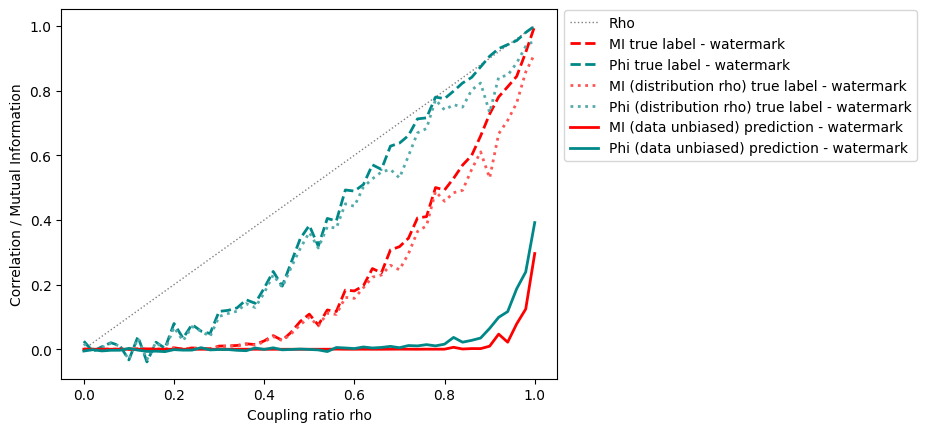

In [242]:
import pickle
biases = list(np.round(np.linspace(0, 1, 51), 3))
with open("m1_mi_6400.pickle", "rb") as f:
    m1_mi = pickle.load(f)
with open("gt_measures_1280.pickle", "rb") as f:
    gt_measures = pickle.load(f)
mimean = torch.mean(m1_mi, dim=1)
plt.plot(biases, biases,linewidth=1, label="Rho", linestyle="dotted", color="gray")
plt.plot(biases, gt_measures[:,0,0],linewidth=2, label="MI true label - watermark", linestyle="dashed", color="#f00")
plt.plot(biases, gt_measures[:,0,1],linewidth=2, label="Phi true label - watermark", linestyle="dashed", color="#088")

plt.plot(biases, torch.mean(gt_measures[:,:,2], dim=1),linewidth=2, label="MI (distribution rho) true label - watermark", linestyle="dotted", color="#f55")
plt.plot(biases, torch.mean(gt_measures[:,:,3], dim=1),linewidth=2, label="Phi (distribution rho) true label - watermark", linestyle="dotted", color="#5aa")
plt.plot(biases, mimean[:,0],linewidth=2, label="MI (data unbiased) prediction - watermark", color="#f00")
plt.plot(biases, mimean[:,1],linewidth=2, label="Phi (data unbiased) prediction - watermark", color="#088")

 
plt.ylabel("Correlation / Mutual Information")
plt.xlabel("Coupling ratio rho")
plt.legend(bbox_to_anchor=(1., 0.57,0.6, 0.0), loc='lower left',ncols=1, )
#(0., -0.53, 1., .102)

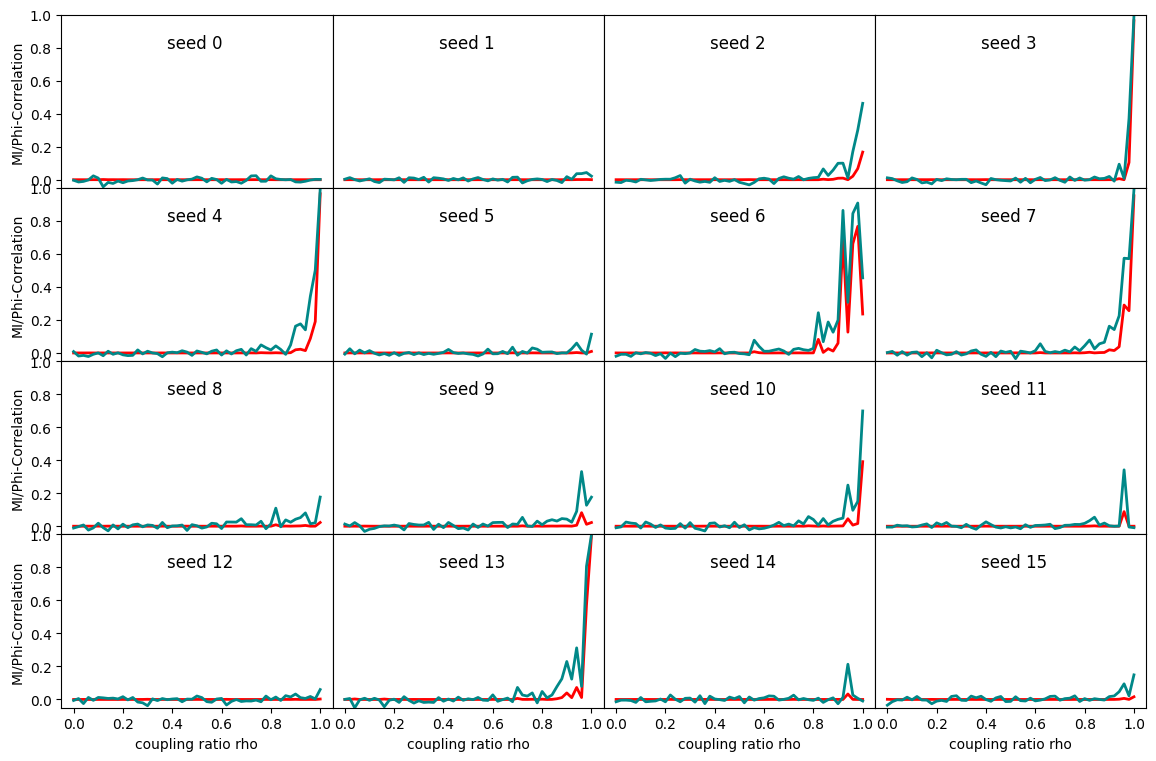

In [241]:
import pickle

with open("m1_mi_6400.pickle", "rb") as f:
    m1_mi = pickle.load(f)
    
biases = list(np.round(np.linspace(0, 1, 51), 3))
fig, axs = plt.subplots(
        4,
        4,
        figsize=(
            14,
            9,
        ),
        gridspec_kw={"wspace": 0.0, "hspace": 0},
    )
for s in range(16):
    axs[s //4, s % 4].set_ylim([-0.05, 1])
    axs[s //4, s % 4].set_xlabel("coupling ratio rho")
    axs[s //4, s % 4].set_ylabel("MI/Phi-Correlation")
    if s // 4 != 3 :
        axs[s //4, s % 4].xaxis.set_visible(False)
    if s % 4 != 0:
        axs[s //4, s % 4].yaxis.set_visible(False)
    axs[s //4, s % 4].text(
        0.38, 0.8,
        f"seed {s}",
        size=12,
    )
    axs[s //4, s % 4].plot(biases, m1_mi[:,s,0],linewidth=2, label="MI (data unbiased) prediction - watermark", color="#f00")
    axs[s //4, s % 4].plot(biases, m1_mi[:,s,1],linewidth=2, label="Phi (data unbiased) prediction - watermark", color="#088")

In [243]:
with open("all_measures_100.pickle", "rb") as f:
    per_sample = pickle.load(f)

torch.Size([51, 16, 100, 22]) torch.Size([51, 22])
torch.Size([51, 22])


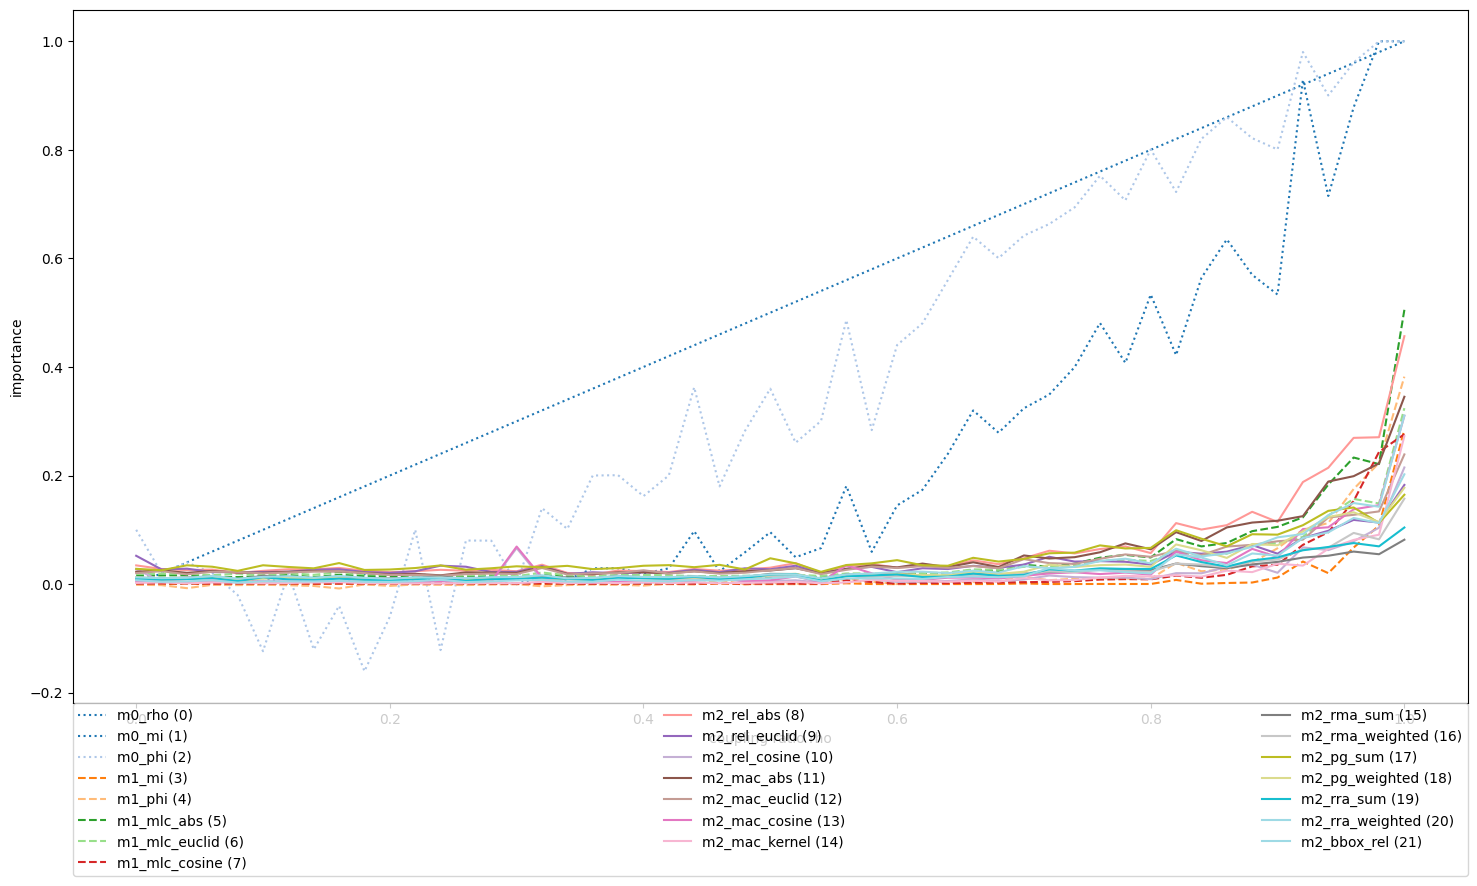

In [285]:
biases = list(np.round(np.linspace(0, 1, 51), 3))
takeing = range(len(ALL_MEASURES))
#m_per_rho = torch.sum(data, dim=(1, 2))
ls = ["dotted", "dashed", "solid"]
per_rho = torch.mean(per_sample, dim=(1,2))
print(per_sample.shape, per_rho.shape)
normalized = per_rho / torch.max(per_rho, dim=0).values
print(normalized.shape)

colors = matplotlib.cm.tab20(np.linspace(0, 1, len(ALL_MEASURES)))#len(takeing)))
use_m = []
plt.figure(figsize=(18,9))
for en, i in enumerate(takeing):
    #for s in range(16):
    l = ALL_MEASURES[i]
    label = f"{l} ({i})" #if s == 0 else ""
    vals = per_rho[:,i] / enums[i][2] #normalized[:,i],
    if  l: #.startswith("m2_mac") #"bbox" in l or "kernel" in
        plt.plot(
            biases,
            vals,
            label=label,
            linestyle=ls[int(l[1])],
            c=colors[en],
        )  

#plt.title("All measures summed over samples and seeds")
plt.ylabel("importance")
plt.xlabel("coupling ratio rho")
plt.legend(bbox_to_anchor=(0., -0.25, 1., .102), loc='lower left',
                      ncols=3, mode="expand", borderaxespad=0.)


tensor([0.0132, 0.0301, 0.1607, 0.0731, 0.1124, 0.0020, 0.0054, 0.0033, 0.0000,
        0.0639, 0.0885, 0.0250, 0.0219, 0.0481, 0.0294, 0.0060, 0.0000, 0.0017,
        0.0705, 0.0146, 0.0191, 0.0007, 0.0112, 0.0232, 0.0817, 0.0774, 0.0000,
        0.0648, 0.0248, 0.0854, 0.0000, 0.0000]) tensor(0.1158)


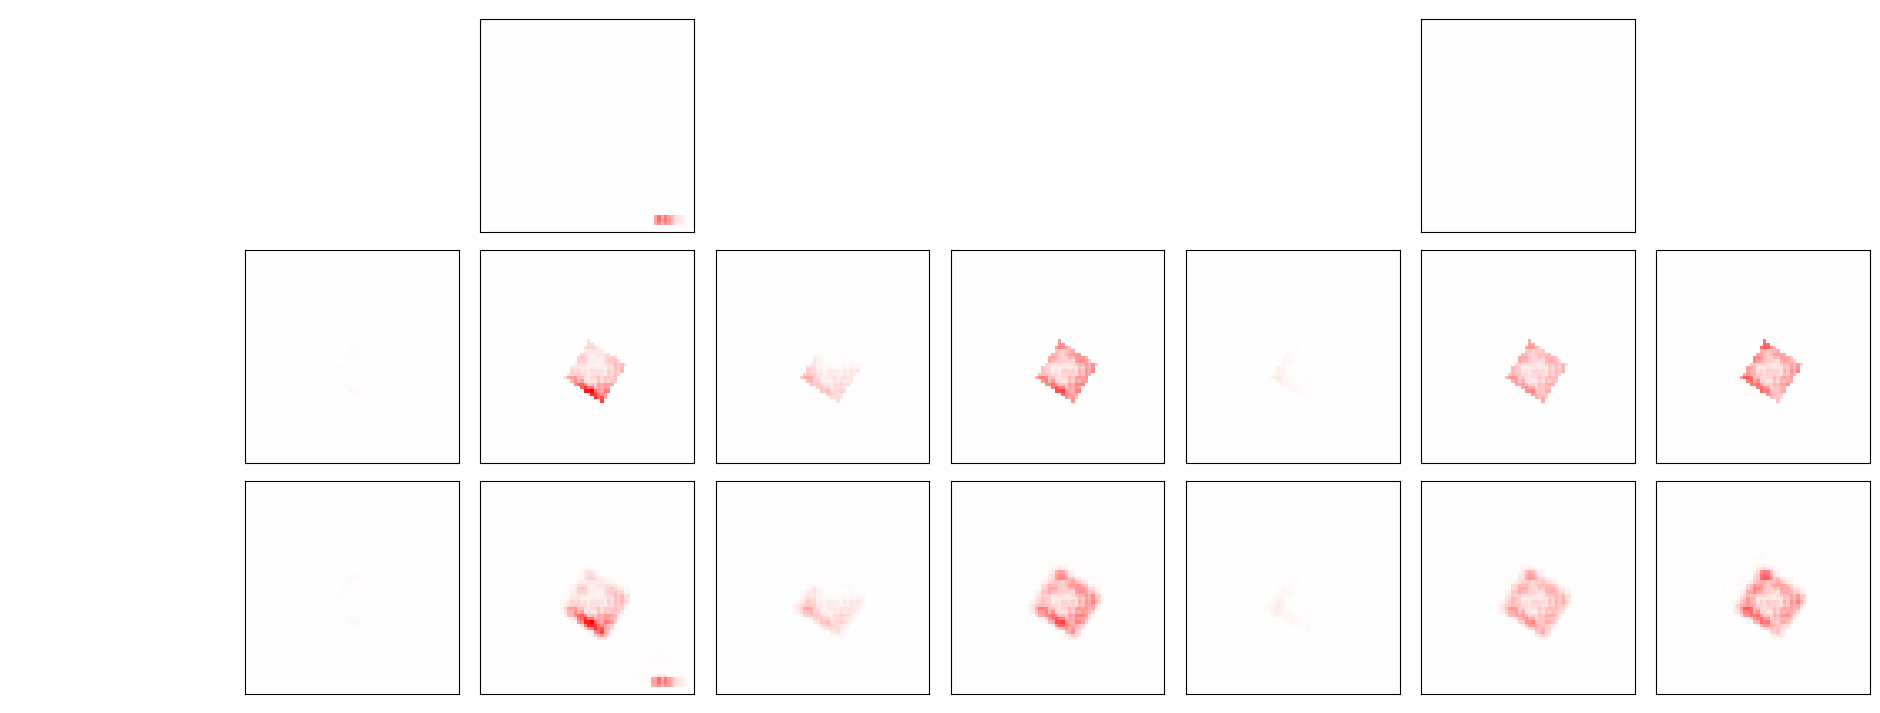

In [7]:
from measures0_to_2 import AllMeasures

bias = 1.0
num_it = 2
name = to_name(bias, num_it)
NAME = "../clustermodels/final"
ms = AllMeasures("../dsprites-dataset/images/", 5)
layer_name = "convolutional_layers.6"
index = 98900
model = load_model(NAME, bias, num_it)
crpa = CRPAttribution(model, ms.ds, "test", name)

image = ms.ds.load_image_wm(index, True)
image0 = ms.ds.load_image_wm(index, False)

lat, _, offset = ms.ds.get_item_info(index)

wm_mask = torch.zeros(64, 64)
wm_mask[
    max(0, 57 + offset[0]) : max(0, 58 + offset[0]) + 5,
    max(offset[1] + 3, 0) : max(offset[1] + 4, 0) + 10,
] = 1
shape_mask = ms.ds.load_shape_mask(index)
nlen = 8
conditions = [{layer_name: [i]} for i in crpa.layer_id_map[layer_name]]
res = 0.0

images = torch.zeros(3, nlen, 64, 64)
for attr in crpa.attribution.generate(
    image,
    conditions,
    crpa.composite,
    start_layer="linear_layers.2",
    record_layer=crpa.layer_names,
    verbose=False,
    batch_size=nlen,
):
    heatmaps_abs = attr.heatmap.abs()
    total_rel = torch.sum(heatmaps_abs, dim=(1, 2))
    images[0, :, :, :] = heatmaps_abs * wm_mask
    images[1, :, :, :] = heatmaps_abs * shape_mask[0]
    images[2, :, :, :] = heatmaps_abs
    wm_rel = torch.sum(heatmaps_abs * wm_mask, dim=(1, 2))
    shape_rel = torch.sum(heatmaps_abs * shape_mask[0], dim=(1, 2))
    vals = torch.zeros(nlen)
    for i in range(nlen):
        if wm_rel[i] > (shape_rel[i] * (wm_mask.sum() / (shape_mask.sum()))):
            vals[i] = wm_rel[i]
        else:
            vals[i] = 0
images = images.detach()
my_plot_grid(images, 3, nlen, resize=3, norm=True)

In [8]:
image1 = ms.ds.load_image_wm(index, True)
image0 = ms.ds.load_image_wm(index, False)

diff_heatmaps = torch.zeros(2, nlen, 64, 64)
hm1 = ms.heatmaps(image1, crpa)
hm0 = ms.heatmaps(image0, crpa)

predv_0 = model(image0)
predv_1 = model(image1)

diff_heatmaps[0, :, :, :] = hm1
diff_heatmaps[1, :, :, :] = hm0
#my_plot_grid(diff_heatmaps, 2, nlen, resize=3, norm=True)
def kernel(a,b):
    return torch.nn.functional.conv2d(a, a) - 2*torch.nn.functional.conv2d(a, b) + torch.nn.functional.conv2d(b, b) 
def kernel1d(a,b):
    return torch.nn.functional.conv1d(a, a) - 2*torch.nn.functional.conv1d(a, b) + torch.nn.functional.conv1d(b, b) 

truediff = kernel(wm_mask.view(1,1,64,64), shape_mask.view(1,1,64,64)) 
diffs = []
predv_0, predv_1 = predv_0 / 6.1175, predv_1 / 6.1175
print(predv_0 , predv_1 ,kernel1d(predv_0.view(1,1,2),predv_1.view(1,1,2)), ms.euclidean_distance(predv_1, predv_0))
batched = kernel(hm1.view(nlen,1,64,64), hm0.view(nlen,1,64,64))
#print(float(truediff), [float(batched[i,i].flatten()) for i in range(8)], sum([float(batched[i,i].flatten()) for i in range(8)]))
#my_plot_grid(diff_heatmaps, 2, nlen, resize=3, norm=True)


tensor([[ 1.1417, -0.4423]], grad_fn=<DivBackward0>) tensor([[ 0.7832, -0.1474]], grad_fn=<DivBackward0>) tensor([[[0.2155]]], grad_fn=<AddBackward0>) 0.18329811096191406


In [291]:
(3750*12) - 6427

38573

In [289]:
(1200 + 400 + 700 ) * 12

27600

In [305]:
4166 * 0.6

2499.6